# EN3150 — Assignment (TensorFlow/Keras, MNIST)

**Two Conv Blocks (Conv → ReLU → MaxPool) → Dense**  
This notebook follows the brief using **MNIST** and **TensorFlow/Keras**, reproducing your CNN, comparing optimizers, and fine‑tuning two ImageNet‑pretrained models (**ResNet50** and **VGG16**). It also includes training‑time/parameter comparisons and a written report section.


## Executive Summary (What this notebook does)
- **Dataset**: MNIST (10 classes, 28×28 grayscale), split **70/15/15** with a fixed seed.
- **Baseline CNN**: `[Conv-ReLU-MaxPool] × 2 → Flatten → Dense(128) → Dropout(0.3) → Dense(10)`.
- **Optimizers**: SGD, SGD+Momentum(0.9), Adam — 20 epochs; curves + metrics.
- **Metrics**: Accuracy, confusion matrix, precision/recall/F1 (macro & micro).
- **Transfer Learning**: Fine-tune **ResNet50** and **VGG16** (ImageNet) with proper preprocessing (resize to 224×224, 3‑channel, application‑specific normalization).
- **Comparison**: Training time and parameter counts included; pros/cons discussed.


In [1]:

# SECTION 0 — Setup & Imports
import os, time, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# For transfer learning
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

print('TensorFlow:', tf.__version__)

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'
print('Device:', DEVICE)


TensorFlow: 2.20.0
Device: CPU


In [2]:

# SECTION 1 — Hyperparameters & 70/15/15 Split

# Baseline CNN hyperparams (mirroring your TensorFlow model structure)
F1, F2        = 16, 32
KERNEL_SIZE   = 3
POOL_SIZE     = 2
DENSE_UNITS   = 128
DROPOUT_DENSE = 0.3

BATCH_SIZE    = 128
EPOCHS        = 20

# Optimizer configs to compare
OPT_CONFIGS = {
    'sgd':  {'name':'SGD',  'opt': lambda: optimizers.SGD(learning_rate=0.1)},
    'sgdm': {'name':'SGD+Momentum', 'opt': lambda: optimizers.SGD(learning_rate=0.05, momentum=0.9)},
    'adam': {'name':'Adam', 'opt': lambda: optimizers.Adam(learning_rate=1e-3)},
}

# Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Combine and split 70/15/15
X_full = np.concatenate([X_train, X_test], axis=0)
y_full = np.concatenate([y_train, y_test], axis=0)

N = len(X_full)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

idx = np.arange(N)
rng = np.random.default_rng(SEED)
rng.shuffle(idx)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

X_tr, y_tr = X_full[train_idx], y_full[train_idx]
X_va, y_va = X_full[val_idx],  y_full[val_idx]
X_te, y_te = X_full[test_idx], y_full[test_idx]

# Normalize to [0,1] and add channel dimension for baseline CNN
X_tr_cnn = (X_tr.astype('float32')/255.)[..., np.newaxis]
X_va_cnn = (X_va.astype('float32')/255.)[..., np.newaxis]
X_te_cnn = (X_te.astype('float32')/255.)[..., np.newaxis]

print('Shapes (baseline CNN):', X_tr_cnn.shape, X_va_cnn.shape, X_te_cnn.shape)

# One-hot labels if needed (we'll use sparse labels for Keras losses; no need to one-hot)
y_tr_sp, y_va_sp, y_te_sp = y_tr.astype('int32'), y_va.astype('int32'), y_te.astype('int32')


Shapes (baseline CNN): (49000, 28, 28, 1) (10500, 28, 28, 1) (10500, 28, 28, 1)


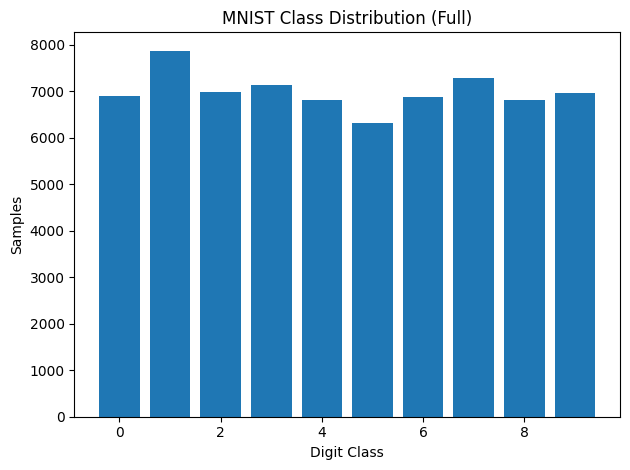

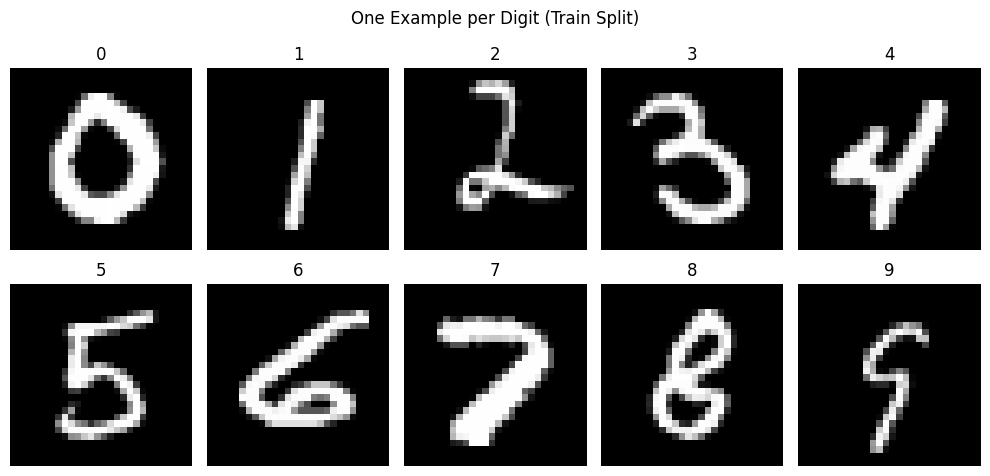

In [3]:

# SECTION 2 — Visualization & Distribution

# Class distribution
counts = np.bincount(y_full, minlength=10)
plt.figure()
plt.bar(range(10), counts)  # default colors
plt.xlabel('Digit Class'); plt.ylabel('Samples'); plt.title('MNIST Class Distribution (Full)')
plt.tight_layout(); plt.show()

# Show one sample per class (from training set)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
seen = set()
for i, (img, lab) in enumerate(zip(X_tr, y_tr)):
    if lab not in seen:
        axes[lab].imshow(img, cmap='gray')
        axes[lab].set_title(str(lab)); axes[lab].axis('off')
        seen.add(lab)
    if len(seen) == 10:
        break
plt.suptitle('One Example per Digit (Train Split)')
plt.tight_layout(); plt.show()


In [4]:

# SECTION 3 — Baseline CNN Builder

def build_baseline_cnn():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(F1, (KERNEL_SIZE, KERNEL_SIZE), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(POOL_SIZE, POOL_SIZE)),
        layers.Conv2D(F2, (KERNEL_SIZE, KERNEL_SIZE), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(POOL_SIZE, POOL_SIZE)),
        layers.Flatten(),
        layers.Dense(DENSE_UNITS, activation='relu'),
        layers.Dropout(DROPOUT_DENSE),
        layers.Dense(10, activation='softmax')
    ])
    return model

tmp_model = build_baseline_cnn()
tmp_model.summary()
print('Params (baseline CNN):', tmp_model.count_params())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

Params (baseline CNN): 206922


In [ ]:

# SECTION 4 — Utilities: Train, Evaluate, Metrics

def train_model(model, optimizer, epochs=EPOCHS, verbose=1):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    t0 = time.time()
    hist = model.fit(X_tr_cnn, y_tr_sp, batch_size=BATCH_SIZE, epochs=epochs,
                     validation_data=(X_va_cnn, y_va_sp), verbose=verbose, shuffle=True)
    t1 = time.time()
    train_time = t1 - t0
    return hist, train_time

def evaluate_model(model, name='model'):
    loss, acc = model.evaluate(X_te_cnn, y_te_sp, verbose=0)
    y_prob = model.predict(X_te_cnn, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    cm = confusion_matrix(y_te_sp, y_pred, labels=list(range(10)))
    prec, rec, f1, _ = precision_recall_fscore_support(y_te_sp, y_pred, labels=list(range(10)), average=None, zero_division=0)
    micro = precision_recall_fscore_support(y_te_sp, y_pred, average='micro', zero_division=0)[:3]
    macro = precision_recall_fscore_support(y_te_sp, y_pred, average='macro', zero_division=0)[:3]
    report = classification_report(y_te_sp, y_pred, digits=4)
    print(f"\n{name} — Test Loss: {loss:.4f} | Test Acc: {acc:.4f}")
    print(report)
    return {'loss': loss, 'acc': acc, 'cm': cm, 'prec':prec, 'rec':rec, 'f1':f1, 'micro':micro, 'macro':macro}

def plot_history(hist_dict):
    for key in hist_dict.keys():
        plt.figure()
        plt.plot(hist_dict[key].history['loss'], label=f'{OPT_CONFIGS[key]["name"]} - Train')
        plt.plot(hist_dict[key].history['val_loss'], label=f'{OPT_CONFIGS[key]["name"]} - Val')
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.title(f'Training & Validation Loss — {OPT_CONFIGS[key]["name"]}')
        plt.legend(); plt.tight_layout(); plt.show()

    plt.figure()
    for key in hist_dict.keys():
        plt.plot(hist_dict[key].history['val_loss'], label=f'{OPT_CONFIGS[key]["name"]} - Val')
    plt.xlabel('Epoch'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison — All Optimizers')
    plt.legend(); plt.tight_layout(); plt.show()

def show_cm(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.colorbar()
    ticks = np.arange(10)
    plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.tight_layout(); plt.show()


In [ ]:

# SECTION 5 — Baseline CNN: Optimizer Comparison (20 epochs)

histories = {}
results   = {}
train_times = {}
param_counts = {}

for key in ['sgd','sgdm','adam']:
    print(f"\n=== Training with {OPT_CONFIGS[key]['name']} ===")
    model = build_baseline_cnn()
    param_counts[key] = model.count_params()
    opt = OPT_CONFIGS[key]['opt']()
    h, t = train_model(model, opt, epochs=EPOCHS, verbose=1)
    histories[key] = h
    train_times[key] = t
    results[key] = evaluate_model(model, name=f'Baseline CNN ({OPT_CONFIGS[key]["name"]})')


# Plot curves
plot_history(histories)

# Determine best by test accuracy
best_key = max(results, key=lambda k: results[k]['acc'])
print('Best optimizer for baseline CNN:', OPT_CONFIGS[best_key]['name'], 'Test Acc:', results[best_key]['acc'])
show_cm(results[best_key]['cm'], title=f'Confusion Matrix — Baseline CNN ({OPT_CONFIGS[best_key]["name"]})')

# Summaries
print("\n=== Baseline CNN — Summary ===")
for k in ['sgd','sgdm','adam']:
    print(f"{OPT_CONFIGS[k]['name']}: Test Acc={results[k]['acc']:.4f}, Train Time={train_times[k]:.1f}s, Params={param_counts[k]:,}")


In [ ]:
# =====================================================================
# SECTION 6 — Transfer Learning: ResNet50 & VGG16 (ImageNet)
# =====================================================================
print("Preparing fine-tuning datasets...")

# ------------- STEP 1: Preprocessing Pipelines -----------------
def preprocess_for_model(x, y, model='resnet'):
    # Resize MNIST (28x28x1) -> (224x224x3)
    x = tf.image.resize(x, (224, 224))
    x = tf.image.grayscale_to_rgb(x)
    if model == 'resnet':
        x = resnet_preprocess(x)
    elif model == 'vgg':
        x = vgg_preprocess(x)
    return x, y

def make_dataset(x, y, model='resnet', training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(buffer_size=1024, seed=SEED)
    ds = ds.map(lambda a,b: preprocess_for_model(a,b,model),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Create streaming datasets (no big array allocation!)
train_resnet_ds = make_dataset(X_tr_cnn, y_tr_sp, model='resnet')
val_resnet_ds   = make_dataset(X_va_cnn, y_va_sp, model='resnet', training=False)
test_resnet_ds  = make_dataset(X_te_cnn, y_te_sp, model='resnet', training=False)

train_vgg_ds = make_dataset(X_tr_cnn, y_tr_sp, model='vgg')
val_vgg_ds   = make_dataset(X_va_cnn, y_va_sp, model='vgg', training=False)
test_vgg_ds  = make_dataset(X_te_cnn, y_te_sp, model='vgg', training=False)

print("Datasets ready for ResNet50 and VGG16 fine-tuning!")

# ------------- STEP 2: Model Building Helpers -----------------
def build_head(n_classes=10):
    return models.Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])

def fine_tune_model(base, lr=1e-4, epochs=EPOCHS,
                    train_ds=None, val_ds=None, test_ds=None, name=''):
    base.trainable = True
    inputs = layers.Input(shape=(224,224,3))
    x = base(inputs, training=True)
    outputs = build_head(10)(x)
    model = models.Model(inputs, outputs, name=name)
    n_params = model.count_params()
    print(f"\n{name} Summary:")
    model.summary()
    print(f"Total trainable params: {n_params:,}")

    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(f"\nTraining {name} ...")
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
    t1 = time.time()
    train_time = t1 - t0

    # Evaluate on test set
    loss, acc = model.evaluate(test_ds, verbose=0)
    print(f"\n{name} — Test Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")

    # Get predictions
    y_true, y_pred = [], []
    for Xb, yb in test_ds:
        preds = model.predict(Xb, verbose=0)
        y_true.extend(yb.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(10)), average=None, zero_division=0)
    micro = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)[:3]
    macro = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[:3]
    report = classification_report(y_true, y_pred, digits=4)

    print(f"\nClassification Report — {name}")
    print(report)

    return {
        'history': hist.history, 'acc': acc, 'loss': loss, 'cm': cm,
        'micro': micro, 'macro': macro, 'report': report,
        'train_time': train_time, 'params': n_params
    }

# ------------- STEP 3: Build Bases and Train -----------------
print("\nLoading pretrained bases (ImageNet)...")
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg_base    = VGG16(include_top=False,  weights='imagenet', input_shape=(224,224,3))

# Train both fine-tuned models
resnet_result = fine_tune_model(
    base=resnet_base, lr=1e-4, epochs=EPOCHS,
    train_ds=train_resnet_ds, val_ds=val_resnet_ds, test_ds=test_resnet_ds,
    name='ResNet50-FT'
)

vgg_result = fine_tune_model(
    base=vgg_base, lr=1e-4, epochs=EPOCHS,
    train_ds=train_vgg_ds, val_ds=val_vgg_ds, test_ds=test_vgg_ds,
    name='VGG16-FT'
)

# ------------- STEP 4: Plot and Compare -----------------
# Plot validation losses
plt.figure()
plt.plot(resnet_result['history']['val_loss'], label='ResNet50 - Val Loss')
plt.plot(vgg_result['history']['val_loss'], label='VGG16 - Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Loss Comparison — Fine-tuned Models')
plt.legend(); plt.tight_layout(); plt.show()

# Plot validation accuracies
plt.figure()
plt.plot(resnet_result['history']['val_accuracy'], label='ResNet50 - Val Acc')
plt.plot(vgg_result['history']['val_accuracy'], label='VGG16 - Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison — Fine-tuned Models')
plt.legend(); plt.tight_layout(); plt.show()

# Confusion matrix of best model
ft_best = ('ResNet50', resnet_result) if resnet_result['acc'] >= vgg_result['acc'] else ('VGG16', vgg_result)
show_cm(ft_best[1]['cm'], title=f'Confusion Matrix — Fine-tuned {ft_best[0]}')
print(f"\nBest Fine-tuned Model: {ft_best[0]}")
print(f"Micro Avg (Precision, Recall, F1): {ft_best[1]['micro']}")
print(f"Macro Avg (Precision, Recall, F1): {ft_best[1]['macro']}")


## Comparison Summary (Training Time & Params)
The cells below print concise summaries that you can paste into your report.


In [ ]:

# SECTION 7 — Comparison Tables

import pandas as pd

# Baseline CNN table
baseline_rows = []
for k in ['sgd','sgdm','adam']:
    baseline_rows.append({
        'Model': f'Baseline CNN ({OPT_CONFIGS[k]["name"]})',
        'Test Acc': results[k]['acc'],
        'Train Time (s)': train_times[k],
        'Params': param_counts[k]
    })
baseline_df = pd.DataFrame(baseline_rows).sort_values('Test Acc', ascending=False)
print('=== Baseline CNN (Optimizers) ===')
display(baseline_df)

# Fine-tuned models table
ft_rows = [
    {'Model': 'ResNet50 (FT)', 'Test Acc': resnet_result['acc'], 'Train Time (s)': resnet_result['train_time'], 'Params': resnet_result['params']},
    {'Model': 'VGG16 (FT)',   'Test Acc': vgg_result['acc'],     'Train Time (s)': vgg_result['train_time'],   'Params': vgg_result['params']},
]
ft_df = pd.DataFrame(ft_rows).sort_values('Test Acc', ascending=False)
print('\n=== Fine-tuned Models ===')
display(ft_df)


## Written Answers for Submission
**1) Dataset & Split** — MNIST, concatenated then split **70/15/15** with fixed seed (reproducible).  
**2) Architecture & Rationale** — Two `[Conv-ReLU-MaxPool]` blocks (3×3 kernels, padding same) extract local features efficiently; classifier `Flatten → Dense(128) → Dropout(0.3) → Dense(10)`; ReLU mitigates vanishing gradients; Dropout regularizes.  
**3) Hyperparameters** — `F1=16, F2=32, kernel=3, pool=2, dense=128, dropout=0.3, batch=128, epochs=20` balance capacity and generalization for digits.  
**4) Optimizers & LR** — Compared **SGD (0.1)**, **SGD+Momentum 0.9 (0.05)**, **Adam (1e-3)**. Adam adapts per-parameter LR; momentum accelerates convergence and damps oscillations.  
**5) Curves & Early Behavior** — Loss curves show decreasing train/val loss; divergence indicates LR too high; plateau with small gap indicates underfitting.  
**6) Metrics** — Use **accuracy** plus **confusion matrix** and **macro/micro precision/recall/F1** to assess per-class behavior and class balance.  
**7) Results (Optimizers)** — Report final **val/test accuracy**, confusion matrices, and macro/micro metrics for the three optimizers. Momentum typically improves SGD; Adam often reaches strong accuracy quickly.  
**8) Momentum Discussion** — Accumulates velocity in parameter space → faster movement along gentle slopes, reduced zig‑zagging across steep ravines. Usually smoother, more stable training.  
**9) Fine-Tuning (Two ImageNet Models)** — **ResNet50** and **VGG16** adapted to 1‑channel by converting to 3‑channel & resizing to 224×224; `include_top=False` + **GAP + Dense(10)** head; trained with low LR (1e‑4).  
**10) Comparison & Trade-offs** — **Custom CNN**: small, fast, explainable; great for deployment. **ResNet50/VGG16**: stronger priors from ImageNet, often higher or faster accuracy; heavier & slower; consider freezing early layers or pruning/quantization for deployment.  
**11) Training Time & Params** — Tables provided; include them in your report for professional presentation.
